## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from numpy import asarray
from numpy import savetxt
import matplotlib.colors as mcolors
import matplotlib.cm
import matplotlib.patches as mpatches
import umap
import matplotlib as mpl
import scanpy as sc
import scipy
import kmapper as km
from kmapper import jupyter
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import sys
from sklearn import ensemble
import tqdm
from ripser import Rips
from ripser import ripser
from persim import plot_diagrams
from sklearn.metrics.pairwise import euclidean_distances
import umap
from numpy import random
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from mpl_toolkits import mplot3d

In [2]:
# ----------------------- Palettes ------------------------

blue = ["blue", "cornflowerblue", "lightskyblue"]
red = ["maroon", "indianred", "salmon"]
orange = ["orangered","coral", "orange"]
purple = ["indigo", "rebeccapurple", "mediumpurple"]
green = ["darkgreen", "limegreen", "lightgreen"]
yellow = ["darkgoldenrod", "goldenrod", "gold"]
teal = ["darkcyan","lightseagreen","paleturquoise"]

pal_array = np.array([np.array(blue), np.array(red), np.array(orange), np.array(purple), np.array(green), np.array(yellow), np.array(teal)])

custom_palette = pd.DataFrame(pal_array, index = ["blue", "red", "orange", "purple", "green", "yellow", "teal"], columns = ["dark", "medium", "light"])

In [3]:
def persistance_diagram(expression_matrix, color, title_plt):
    
    # Using Ripser, computes the persistent homology (H_0, and H_1), and plots the persistence diagram
    
    # expression_matrix - expression matrix to be fed into Risper (will be transposed)
    # color - "blue", "red", "orange", "purple", "green", "yellow"
    # title_plt - title for returned persistance diagram
    
    # returns - birth-death pairs for lifetime
    
    bd = ripser(expression_matrix.T, maxdim=1)['dgms']
    
    xy_H_0 = bd[0]
    xy_H_1 = bd[1]

    y_max = sorted(list(xy_H_0[:,1]))[-2]
    print(sorted(list(xy_H_0[:,1]))[-1])
    x_max = sorted(list(xy_H_1[:,1]))[-1]
    either_max = np.amax(np.array([x_max, y_max]))
    
    buffer = either_max*0.1
    
    x = np.linspace(-1*buffer,either_max,500)

    plt.figure(figsize=(5, 5))
            
    sns.scatterplot(xy_H_0[:,0], xy_H_0[:,1], hue = np.ones(xy_H_0.shape[0]), s = 5, linewidth=0, palette = [custom_palette.loc[color]["medium"]], label = "H_0")
    sns.scatterplot(xy_H_1[:,0], xy_H_1[:,1], hue = np.ones(xy_H_1.shape[0]), s = 5, linewidth=0, palette = [custom_palette.loc[color]["dark"]], label = "H_1")
    plt.plot(x, x, ':k', label='Birth = Death')
    plt.plot(x, either_max*np.ones(x.shape), ':k', label='Fully Connected Component')
    plt.ylabel('Death')
    plt.xlabel('Birth')
    plt.ylim((-1*buffer,either_max*1.1))
    plt.xlim((-1*buffer,either_max*1.1))
    plt.title(title_plt)
    plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
    #plt.savefig('PersistenceDiagram_'+str(title_plt)+'.png')
    plt.show()
    
    return bd, color

In [4]:
def birth_lifetime(bd, data_type, color, title_plt):
    
    # Generates plot of birth vs. lifetime
    
    # color - "blue", "red", "orange", "purple", "green", "yellow"
    # bd - birth-death pairs for lifetime
    
    if data_type==0:
        y_max = 100
    elif data_type==1:
        y_max = 20
    else:
        y_max = 20
    
    H_1 = np.array(bd[1])
    lifetime = []

    for i in range(H_1.shape[0]):
        lifetime.append(H_1[i, 1] - H_1[i, 0])
    lifetime = np.array(lifetime)

    plt.figure(figsize=(5, 5))
            
    plt.scatter(H_1[:, 0], lifetime, s = 5, linewidth=0, c = custom_palette.loc[color][data_type], label = "H_1")
    plt.ylabel('Lifetime')
    plt.ylim((-1,y_max))
    plt.xlabel('Birth')
    plt.title(title_plt)
    plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
    #plt.savefig('BirthLifetime_'+str(title_plt)+'.png')
    plt.show()

In [5]:
def violin_lifetime(bd, data_type, color, sublabel, title_plt):
    
    # Generates violin plot of lifetimes
    
    # bd and color sane as persistance_diagram
    # data_type refers to 0:All genes, 1:Cell cycle genes, 2:Random genes_1
    
    if data_type==0:
        y_label = "All Genes"
        y_top = 100
    elif data_type==1:
        y_label = "Cell Cycle Genes"
        y_top = 20
    else:
        y_label = "Random Genes"
        y_top = 20
    
    H_1 = np.array(bd[1])
    lifetime = []

    for i in range(H_1.shape[0]):
        lifetime.append(H_1[i, 1] - H_1[i, 0]) #append lifetime of each feature
    
    lifetime = np.reshape(np.array(lifetime), (H_1.shape[0],1))

    plt.figure(figsize=(2,5))
    sns.violinplot(y=lifetime, palette = [custom_palette.loc[color][data_type]])
    sns.swarmplot(x=np.array([y_label]), y=np.array([np.amax(lifetime)]), color=custom_palette.loc[color][0], s = 10)
    plt.ylabel("Lifetime of H1 features")
    plt.xlabel(sublabel, fontsize=8)
    plt.ylim((0,y_top))
    #plt.savefig('ViolinPlot_'+str(title_plt)+'.png')
    plt.show()
    


In [6]:
def visualize(data, pca_n, plot_label, hue):
    
    # Finds 2D and 3D UMAP visualization and plots data in the associated color scheme
    
    # data - gene expression matrix being visualized
    # pca_n - number of PCA components to transfer to UMAP for visualization
    # plot_label - the label of returned plots
    # hue - color scheme used for plotting this data
    
    # returns - embedding (UMAP coordinates), and embedding_3 (3D UMAP coordinates)
    
    pca = PCA(n_components=pca_n)
    pca.fit(data.T)
    X_PCA = pca.transform(data.T)

    reducer = umap.UMAP(random_state=42, n_components=2)
    embedding = reducer.fit_transform(X_PCA)

    
    reducer_3 = umap.UMAP(random_state=42, n_components=3)
    embedding_3 = reducer_3.fit_transform(X_PCA)
    
    LLE = LocallyLinearEmbedding(n_components=pca_n)
    X_LLE = LLE.fit_transform(data.T)

    
    var = np.array(pca.explained_variance_ratio_)
    pcs = np.arange(1,var.shape[0]+1)

    plt.scatter(pcs, var, c = color_selection[hue])
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principle components')
    plt.title("PCA - Explained Variance Ratio")
    plt.savefig('PCA_'+str(plot_label)+'.png')
    plt.show()
    
    plt.figure(figsize=(8, 6))
            
    sns.scatterplot(embedding[:,0], embedding[:,1], hue = np.ones(embedding.shape[0]), s = 20, linewidth=0, palette = [color_selection[hue]])
    plt.ylabel('UMAP2')
    plt.xlabel('UMAP1')
    plt.title(plot_label)
    plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
    plt.savefig('UMAP_'+str(plot_label)+'.png')
    plt.show()
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(embedding_3[:,0], embedding_3[:,1], embedding_3[:,2], c=color_selection[hue])
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_zlabel('UMAP3')
    plt.savefig('3DUMAP_view1_'+str(plot_label)+'.png')
    plt.show()
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(embedding_3[:,1], embedding_3[:,2], embedding_3[:,0], c=color_selection[hue])
    ax.set_xlabel('UMAP2')
    ax.set_ylabel('UMAP3')
    ax.set_zlabel('UMAP1')
    plt.savefig('3DUMAP_view2_'+str(plot_label)+'.png')
    plt.show()
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(embedding_3[:,2], embedding_3[:,0], embedding_3[:,1], c=color_selection[hue])
    ax.set_xlabel('UMAP3')
    ax.set_ylabel('UMAP1')
    ax.set_zlabel('UMAP2')
    plt.savefig('3DUMAP_view3_'+str(plot_label)+'.png')
    plt.show()
    
    
    return embedding, embedding_3, X_PCA, X_LLE

In [7]:
def find_random(size, seed):
    
    # Finds size number of random genes with similar expression level to cell cycles genes
    
    # size - number of random genes
    # seed - random seed for reproducibility
    
    # returns - random genes as a list
    
    np.random.seed(seed)
    CDK1 = "ENSG00000170312"
    UBE2C = "ENSG00000175063"
    TOP2A = "ENSG00000131747"
    #H4C5 = "ENSG00000276966"
    H4C3 = "ENSG00000197061"

    # Cell cycle genes for comparison
    cell_cycle = [CDK1, UBE2C, TOP2A, H4C3]
    compare = gene_expression.loc[cell_cycle]
    
    # Bin expression - find bins for cell cycle genes
    q = 0.05
    quantiles = []
    for i in range(10):
        quantiles.append(np.quantile(gene_expression.values.T, q, axis = 1))
        q += 0.1
    
    quantiles.append(np.quantile(gene_expression.values.T, 1, axis = 1)+1)
    quantiles = np.array(quantiles)
    quantiles = np.mean(quantiles, axis = 1)
    
    
    cell_cycle_bin = []
    for i in range(size):
        loc = np.where(np.mean(gene_expression.loc[cell_cycle[i]]) > quantiles)[0]
        cell_cycle_bin.append(loc[-1])
        
    
    # Take mean expression for finding other genes in bin
    gene_expression_mean = pd.DataFrame(np.mean(gene_expression.values, axis = 1), index = gene_expression.index, columns = ["Mean_exp"])
    
    # For each cell cycle gene - find the bin, sample a random gene from that same bin
    rand_gene_list = []
    for i in cell_cycle_bin:
        range_min = quantiles[i]
        range_max = quantiles[i + 1]
        random_possibilities = gene_expression_mean[(gene_expression_mean["Mean_exp"] > range_min) & (gene_expression_mean["Mean_exp"] < range_max)]
        random_possibilities_index = random_possibilities.index
        
        
        rand_gene_index = np.random.randint(0, random_possibilities_index.shape[0], size=1)
        rand_gene = random_possibilities_index[rand_gene_index][0]
        rand_gene_list.append(rand_gene)
    
    
    return rand_gene_list

In [8]:
def theta_plot(gene_expression, plot_title, embedding, embedding_3, X_PCA, X_LLE):
    
    # Plots values of theta, measurement in radians in terms of cell cycle progression (0, 2pi) on 2D and 3D UMAP
    
    # gene_expression - gene expression matrix used for visualization
    # plot_title - title of output plots
    # embedding - 2D UMAP coordinates found by visualize()
    # embedding_3 - 3D UMAP coordinates found by visualize()
    
    
    labels_theta = np.array(labels["theta"][gene_expression.columns])
    
    plt.figure(figsize=(8, 6))
    n = 8
    #palette = sns.color_palette("hls", n)

    flatui = ["#eb1721", "#770000", "#000000", "#001c34", "#0073c0", "#a9caff", "#ffffff", "#ffaaaa"]
    palette = sns.color_palette(flatui)

    theta_max = 2*3.14
    bin_theta = []
    
    for i in range(0,n):
        bin_theta.append(i*theta_max/n)

    for i in range(labels_theta.shape[0]):
        if labels_theta[i] > theta_max:
            labels_theta[i] = labels_theta[i] - theta_max

    label_bin = []
    for i in range(labels_theta.shape[0]):
        label_bin.append(np.where((labels_theta[i] >= bin_theta))[0][-1])

    label_bin = np.array(label_bin)
    
    print("label: "+repr(label_bin.shape))
    print("UMAP: "+repr(embedding.shape))
    print("PCA: "+repr(X_PCA.shape))
    print("LLe: "+repr(X_LLE.shape))
    
    
    # -------------------------UMAP------------------------------
    
    sns.scatterplot(embedding[:,0], embedding[:,1], hue = label_bin, s = 20, linewidth=0, palette = palette)

    plt.ylabel('UMAP2')
    plt.xlabel('UMAP1')
    plt.title('UMAP - '+str(plot_title)+' - color by binned theta')
    plt.legend()
    #plt.savefig('UMAP_'+str(plot_title)+'_colorbinnedtheta.pdf') 
    plt.show()

    from matplotlib.colors import ListedColormap
    #palette = ListedColormap(sns.color_palette("hls", n).as_hex())

    palette = ListedColormap(sns.color_palette(flatui).as_hex())


    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(embedding_3[:,0], embedding_3[:,1], embedding_3[:,2], c=label_bin, cmap = palette)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_zlabel('UMAP3')
    plt.title('UMAP - '+str(plot_title)+' - color by binned theta')
    #plt.savefig('3DUMAP_view1_'+str(plot_title)+'_colorbinnedtheta.pdf') 
    plt.show()

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(embedding_3[:,1], embedding_3[:,2], embedding_3[:,0], c=label_bin, cmap = palette)
    ax.set_xlabel('UMAP2')
    ax.set_ylabel('UMAP3')
    ax.set_zlabel('UMAP1')
    plt.title('UMAP - '+str(plot_title)+' - color by binned theta')
    #plt.savefig('3DUMAP_view2_'+str(plot_title)+'_colorbinnedtheta.pdf')
    plt.show()

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(embedding_3[:,2], embedding_3[:,0], embedding_3[:,1], c=label_bin, cmap = palette)
    ax.set_xlabel('UMAP3')
    ax.set_ylabel('UMAP1')
    ax.set_zlabel('UMAP2')
    plt.title('UMAP - '+str(plot_title)+' - color by binned theta')
    #plt.savefig('3DUMAP_view3_'+str(plot_title)+'_colorbinnedtheta.pdf')
    plt.show()
    
    
    # -------------------------PCA------------------------------

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2], c=label_bin, cmap = palette)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.title('PCA - '+str(plot_title)+' - color by binned theta')
    #plt.savefig('3DUMAP_view3_'+str(plot_title)+'_colorbinnedtheta.pdf')
    plt.show()
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X_PCA[:,1], X_PCA[:,2], X_PCA[:,0], c=label_bin, cmap = palette)
    ax.set_xlabel('PC2')
    ax.set_ylabel('PC3')
    ax.set_zlabel('PC1')
    plt.title('PCA - '+str(plot_title)+' - color by binned theta')
    #plt.savefig('3DUMAP_view3_'+str(plot_title)+'_colorbinnedtheta.pdf')
    plt.show()
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X_PCA[:,2], X_PCA[:,0], X_PCA[:,1], c=label_bin, cmap = palette)
    ax.set_xlabel('PCP3')
    ax.set_ylabel('PC1')
    ax.set_zlabel('PC2')
    plt.title('PCA - '+str(plot_title)+' - color by binned theta')
    #plt.savefig('3DUMAP_view3_'+str(plot_title)+'_colorbinnedtheta.pdf')
    plt.show()
    
    
    
    
    
    # -------------------------LLE------------------------------
    
    plt.scatter(X_LLE[:,0], X_LLE[:,1], c=label_bin, cmap = palette)
    plt.ylabel('LLE2')
    plt.xlabel('LLE1')
    plt.title('LLE - '+str(plot_title)+' - color by binned theta')
    #plt.savefig('LLE_'+str(plot_title)+'_colorbinnedtheta.pdf')
    plt.show()

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X_LLE[:,0], X_LLE[:,1], X_LLE[:,2], c=label_bin, cmap = palette)
    ax.set_xlabel('LLE1')
    ax.set_ylabel('LLE2')
    ax.set_zlabel('LLE3')
    plt.title('LLE - '+str(plot_title)+' - color by binned theta')
    #plt.savefig('3DLLE_view1_'+str(plot_title)+'_colorbinnedtheta.pdf')
    plt.show()

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X_LLE[:,1], X_LLE[:,2], X_LLE[:,0], c=label_bin, cmap = palette)
    ax.set_xlabel('LLE2')
    ax.set_ylabel('LLE3')
    ax.set_zlabel('LLE1')
    plt.title('LLE - '+str(plot_title)+' - color by binned theta')
    #plt.savefig('3DLLE_view2_'+str(plot_title)+'_colorbinnedtheta.pdf')
    plt.show()

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X_LLE[:,2], X_LLE[:,0], X_LLE[:,1], c=label_bin, cmap = palette)
    ax.set_xlabel('LLE3')
    ax.set_ylabel('LLE1')
    ax.set_zlabel('LLE2')
    plt.title('LLE - '+str(plot_title)+' - color by binned theta')
    #plt.savefig('3DLLE_view3_'+str(plot_title)+'_colorbinnedtheta.pdf')
    plt.show()

In [9]:
def make_plots(data, data_type, n_components, full_title, plot_title, color, sublabel):
    
    # Generate all of the plots for a given gene/cell subset
    
    # data - gene expression matrix
    # data_type - 0: ALl Genes, 1: Cell Cycle Genes, 2: Random Genes, will pick hue for plots
    # n_components - number of components for PCA, LLE
    # full_title - Title given to UMAP plots, fully explains data
    # plot_title - Also used for plots but primary purpose is in saving so should be unique
    # color - color scheme selected for dataset
    # sublabel - list of genes in subset or empty list for violin plot
    
    # Returns UMAP, UMAP colored by theta, persistence diagram, birth-lifetime, and violin plot
    
    embedding, embedding_3, X_PCA, X_LLE = visualize(data, n_components, full_title, data_type)
    theta_plot(data, plot_title, embedding, embedding_3, X_PCA, X_LLE)
    bd, color = persistance_diagram(data.values, color, plot_title)
    birth_lifetime(bd, data_type, color, plot_title)
    violin_lifetime(bd, data_type, color, sublabel, plot_title)

## Read in data

In [10]:
gene_expression = pd.read_csv("final_geneexpression.csv", sep=',', header = 0, index_col = 0)
labels = pd.read_csv("final_labels.csv", sep=',', header = 0, index_col = 0)

In [11]:
gene_expression

20170905-A01  20170905-A02  20170905-A03  20170905-A06  \
EGFP                       22            12            43            31   
ENSG00000000003            14             8             3             7   
ENSG00000000419            11             6             3             4   
ENSG00000000457             0             0             0             0   
ENSG00000000460             3             0             2             4   
...                       ...           ...           ...           ...   
ERCC-00163                  1             0             1             3   
ERCC-00165                  8             4             1             2   
ERCC-00170                  0             1             5             1   
ERCC-00171                147           167           171           154   
mCherry                     1             5             0             0   

                 20170905-A07  20170905-A08  20170905-A09  20170905-A10  \
EGFP                       56            30            28            26   
ENSG00000000003            11            18             3             5   
ENSG00000000419             1             7             9            10   
ENSG00000000457             0             0             1             0   
ENSG00000000460             1             0             4             1   
...                       ...           ...           ...           ...   
ERCC-00163                  1             3             1             0   
ERCC-00165                  3             2             0             2   
ERCC-00170                  1             0             0             0   
ERCC-00171                179           167           168           167   
mCherry                     2             1             3             3   

                 20170905-A11  20170905-A12  ...  20170924-G05  20170924-G06  \
EGFP                       15            27  ...            41            37   
ENSG00000000003             8             9  ...            17             4   
ENSG00000000419             3             9  ...             9            11   
ENSG00000000457             0             0  ...             0             0   
ENSG00000000460             0             1  ...             5             0   
...                       ...           ...  ...           ...           ...   
ERCC-00163                  3             0  ...             1             0   
ERCC-00165                  5             1  ...             1             0   
ERCC-00170                  0             3  ...             0             1   
ERCC-00171                147           166  ...           183           162   
mCherry                     1             3  ...             1             1   

                 20170924-G07  20170924-G09  20170924-G12  20170924-H03  \
EGFP                       46            13            31             3   
ENSG00000000003             8             1             6             2   
ENSG00000000419             3             6             8             7   
ENSG00000000457             0             1             0             0   
ENSG00000000460             3             1             2             0   
...                       ...           ...           ...           ...   
ERCC-00163                  0             0             0             2   
ERCC-00165                  0             1             1             2   
ERCC-00170                  0             2             0             1   
ERCC-00171                170           145           142           168   
mCherry                     2             0             0             0   

                 20170924-H05  20170924-H07  20170924-H08  20170924-H11  
EGFP                        6            35            39            30  
ENSG00000000003            16             9            17             5  
ENSG00000000419            14             7            12             6  
ENSG00000000457             0             4             1

In [12]:
labels

experiment well  cell_number  concentration          ERCC  \
20170905-A01    20170905  A01            1       1.726404  50x dilution   
20170905-A02    20170905  A02            1       1.445693  50x dilution   
20170905-A03    20170905  A03            1       1.889617  50x dilution   
20170905-A06    20170905  A06            1       2.135352  50x dilution   
20170905-A07    20170905  A07            1       1.999640  50x dilution   
...                  ...  ...          ...            ...           ...   
20170924-H03    20170924  H03            1       1.403619  50x dilution   
20170924-H05    20170924  H05            1       2.413250  50x dilution   
20170924-H07    20170924  H07            1       2.498777  50x dilution   
20170924-H08    20170924  H08            1       0.502145  50x dilution   
20170924-H11    20170924  H11            1       1.360470  50x dilution   

             individual.1 individual.2 image_individual  image_label      raw  \
20170905-A01      NA18855      NA18870      18870_18855            3  5746265   
20170905-A02      NA18855      NA18870      18870_18855            2  3997709   
20170905-A03      NA18855      NA18870      18870_18855            1  4765829   
20170905-A06      NA18855      NA18870      18870_18855           51  5249443   
20170905-A07      NA18855      NA18870      18870_18855            6  5084206   
...                   ...          ...              ...          ...      ...   
20170924-H03      NA18870      NA19160      19160_18870           45  3544487   
20170924-H05      NA18870      NA19160      19160_18870           92  4087535   
20170924-H07      NA18870      NA19160      19160_18870           46  3917460   
20170924-H08      NA18870      NA19160      19160_18870           47  4132349   
20170924-H11      NA18870      NA19160      19160_18870           95  3456857   

              ...  rfp.median.log10sum  gfp.median.log10sum  \
20170905-A01  ...             2.744765             2.954637   
20170905-A02  ...             2.252281             2.518825   
20170905-A03  ...             2.850892             3.197764   
20170905-A06  ...             1.761813             2.941773   
20170905-A07  ...             2.021554             3.265179   
...           ...                  ...                  ...   
20170924-H03  ...             1.988120             1.808922   
20170924-H05  ...             1.770559             2.795882   
20170924-H07  ...             2.131801             2.620315   
20170924-H08  ...             1.964830             2.303479   
20170924-H11  ...             2.027374             2.510285   

              dapi.median.log10sum  rfp.median.log10sum.adjust  \
20170905-A01              3.083036                    0.415319   
20170905-A02              2.696254                   -0.013086   
20170905-A03              2.955256                    0.329710   
20170905-A06              3.062226                   -0.231238   
20170905-A07              3.169831                   -0.333604   
...                            ...                         ...   
20170924-H03              2.087316                   -0.251185   
20170924-H05              3.130760                   -0.463508   
20170924-H07              2.995700                   -0.089174   
20170924-H08              2.816438                   -0.498783   
20170924-H11              2.566041                   -0.316964   

              gfp.median.log10sum.adjust  dapi.median.log10sum.adjust  size  \
20170905-A01                    0.149738                     0.269229  1358   
20170905-A02                   -0.260776                    -0.110300   723   
20170905-A03                    0.281079                     0.112117  2937   
20170905-A06                    0.128699                     0.162145  1359   
20170905-A07                    0.420206                     0.224290  1795   
...                                  ...                          ...   ...   
20170924-H03                   -0.948

## Looking for features via PCs

(888, 20)


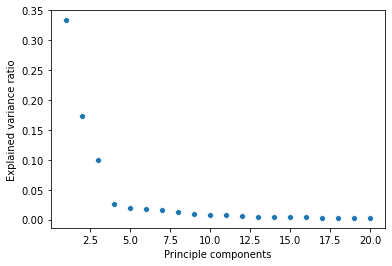

In [13]:
pca = PCA(n_components=20)
pca.fit(gene_expression.values.T)
X = pca.transform(gene_expression.values.T)
print(X.shape)

var = np.array(pca.explained_variance_ratio_)
pcs = np.arange(1,21)

sns.scatterplot(pcs, var)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principle components')
plt.show()

X = X[:,0:4]

data_pcs = pd.DataFrame(X.T, columns = gene_expression.columns)

In [14]:
color_selection = custom_palette.loc["yellow"]

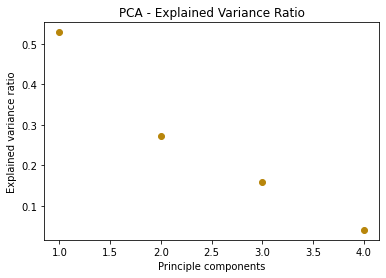

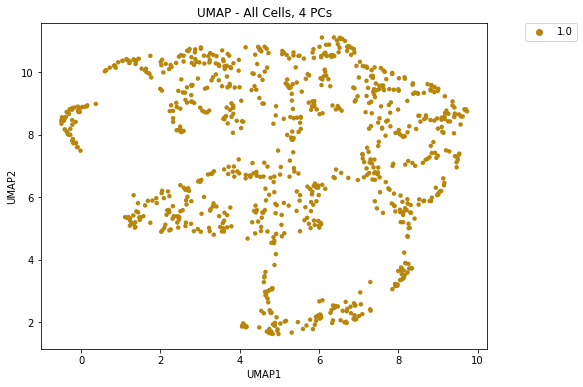

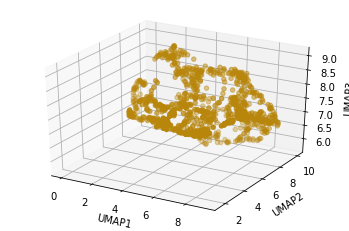

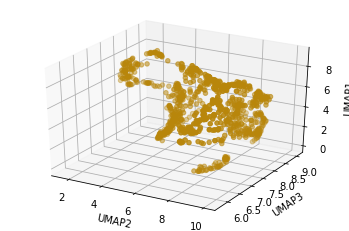

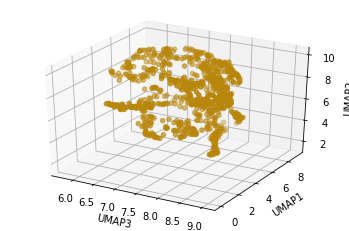

label: (888,)
UMAP: (888, 2)
PCA: (888, 4)
LLe: (888, 4)


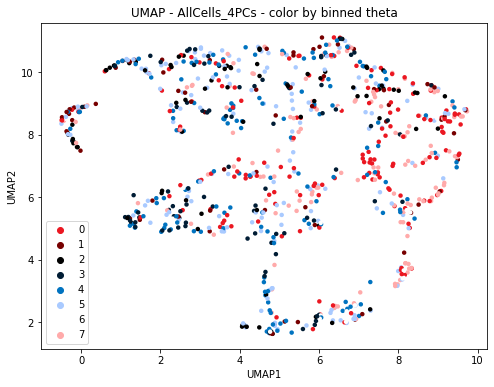

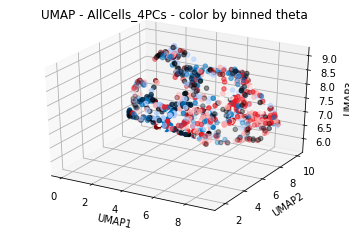

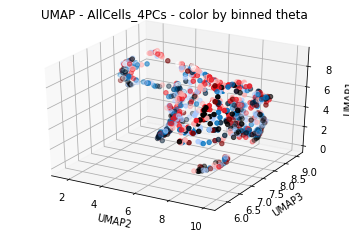

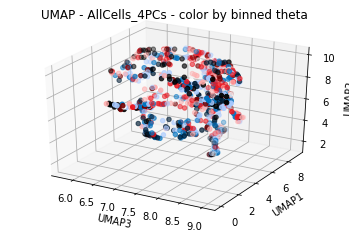

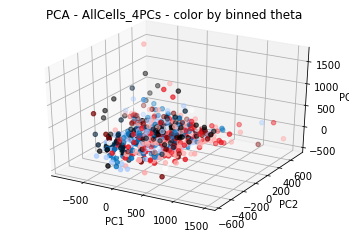

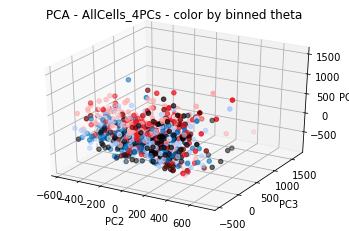

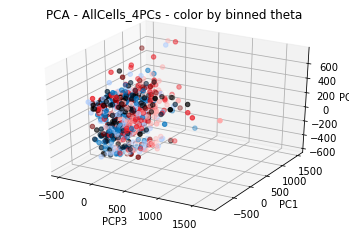

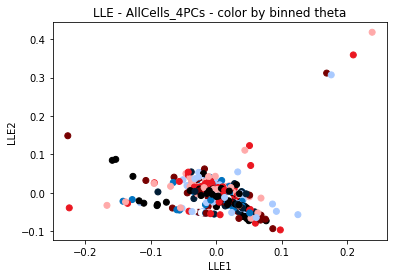

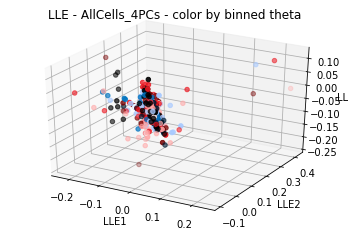

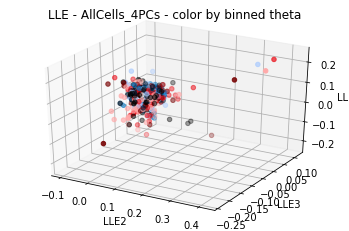

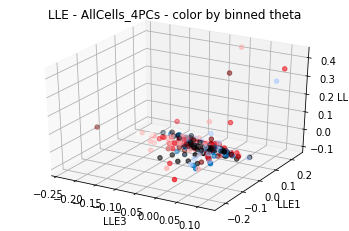

inf


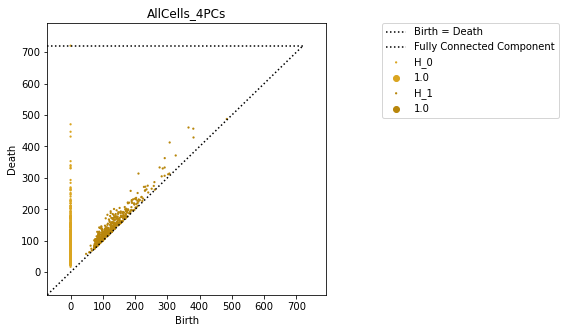

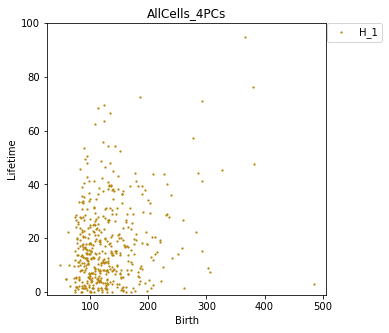

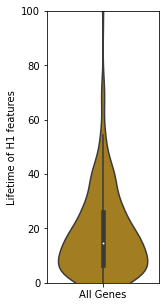

In [15]:
make_plots(data_pcs, 0, 4, 'UMAP - All Cells, 4 PCs', "AllCells_4PCs", "yellow", "")

In [16]:
sublabel = ""

In [17]:
color_selection = custom_palette.loc["blue"]

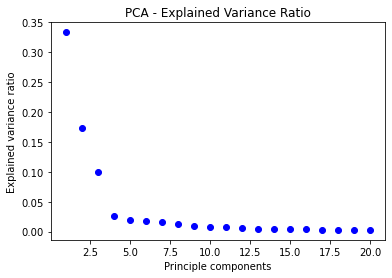

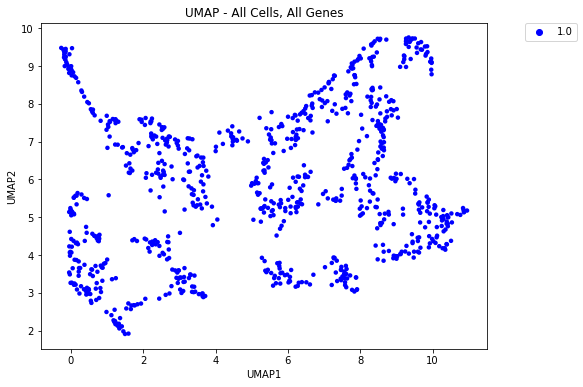

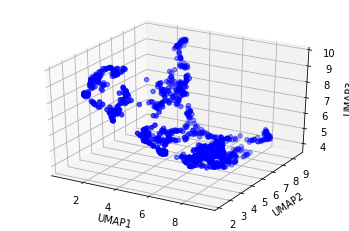

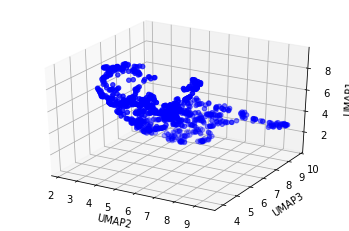

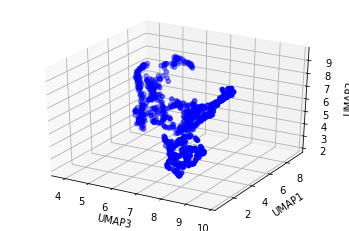

label: (888,)
UMAP: (888, 2)
PCA: (888, 20)
LLe: (888, 20)


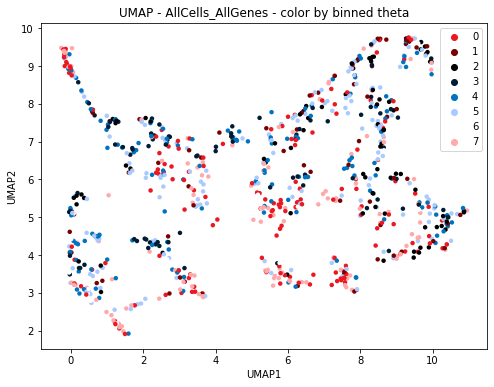

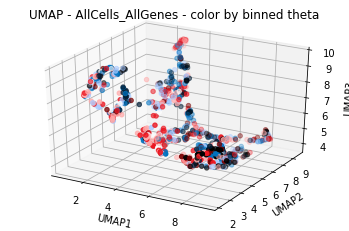

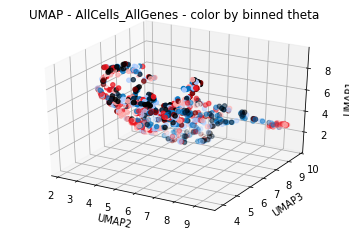

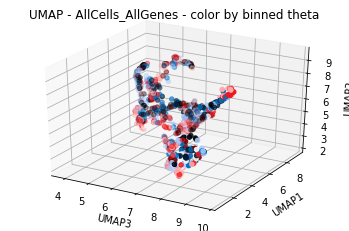

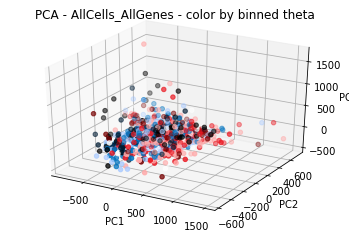

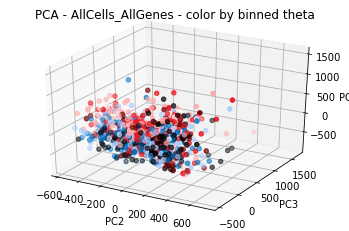

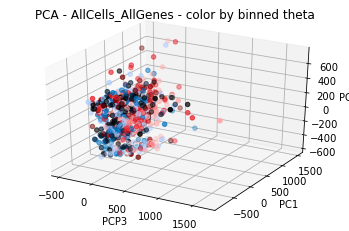

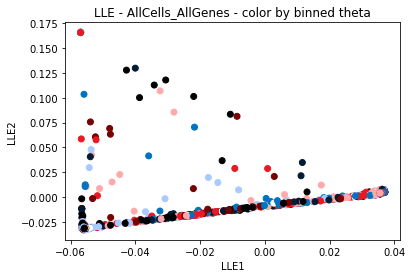

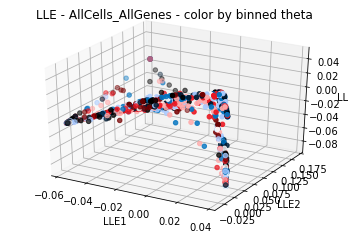

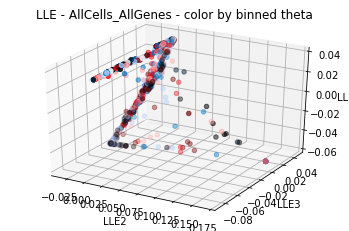

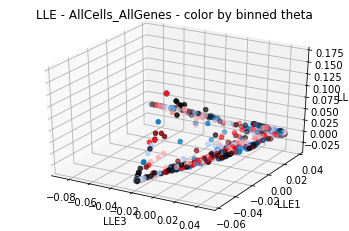

c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\ripser\ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


inf


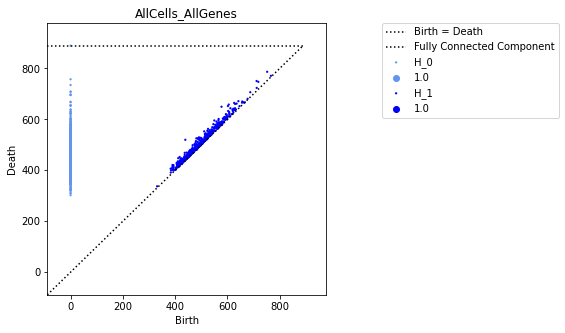

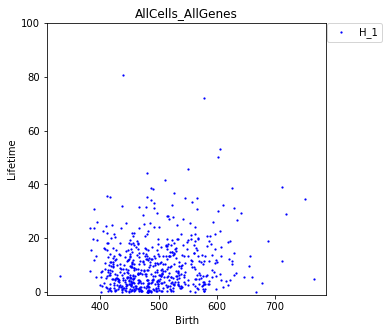

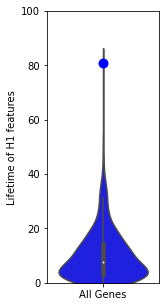

In [18]:
make_plots(gene_expression, 0, 20, 'UMAP - All Cells, All Genes', "AllCells_AllGenes", "blue", sublabel)

## Reduce data to cyclic genes

In [19]:
CDK1 = "ENSG00000170312"
UBE2C = "ENSG00000175063"
TOP2A = "ENSG00000131747"
#H4C5 = "ENSG00000276966"
H4C3 = "ENSG00000197061"

sublabel_cycle = "CDK1, UBE2C, TOP2A, H4C3"

In [20]:
gene_sub = gene_expression.loc[[CDK1, UBE2C, TOP2A, H4C3]]

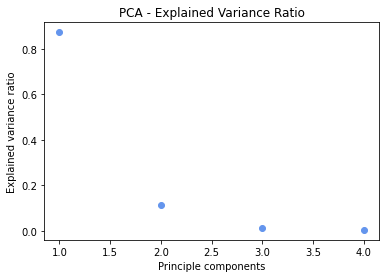

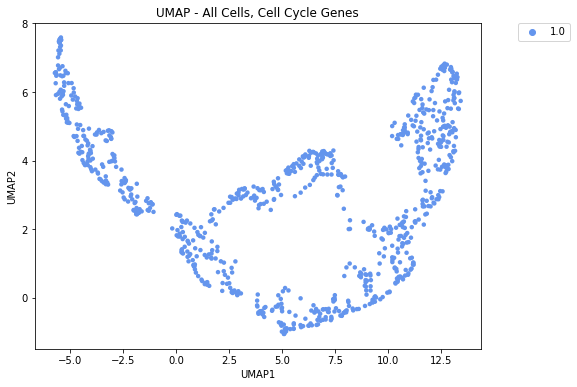

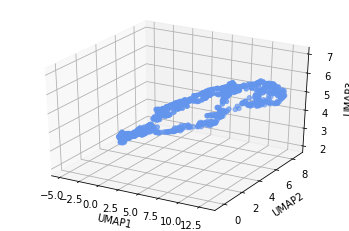

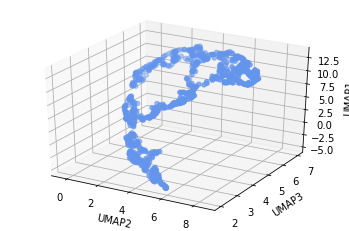

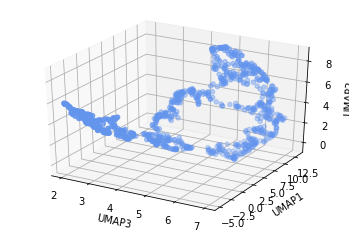

label: (888,)
UMAP: (888, 2)
PCA: (888, 4)
LLe: (888, 4)


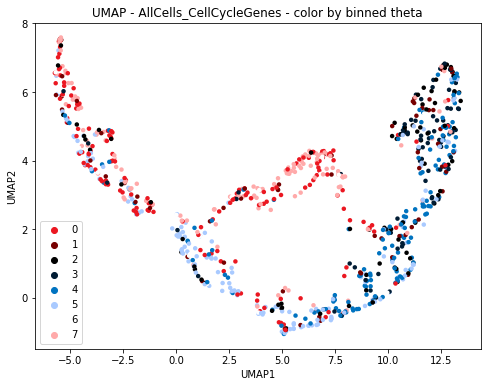

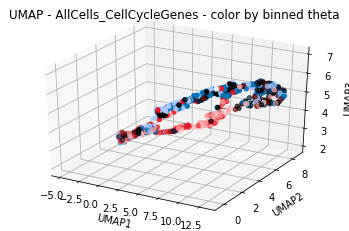

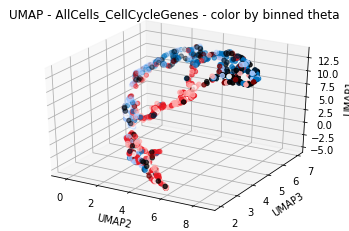

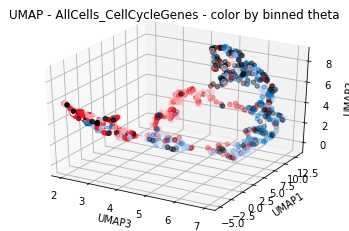

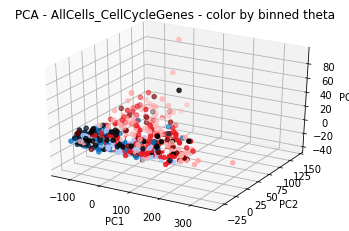

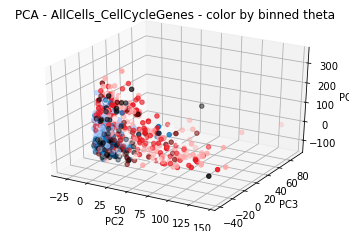

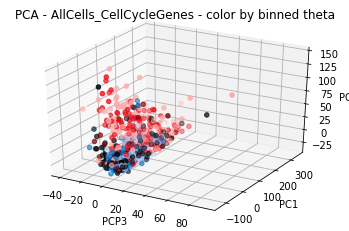

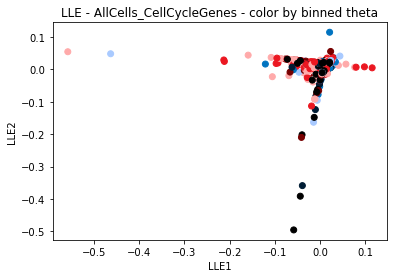

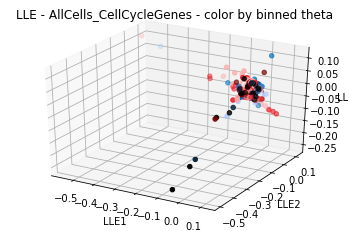

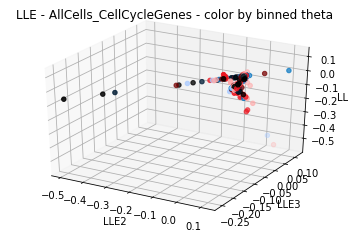

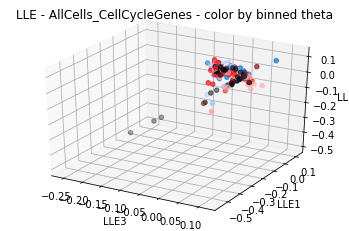

inf


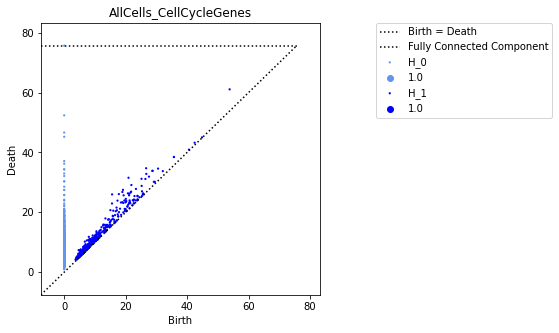

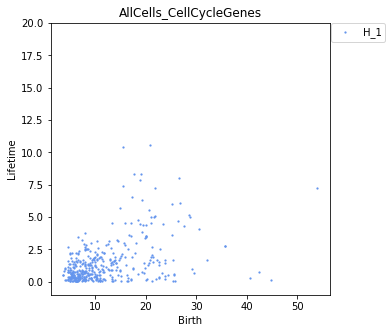

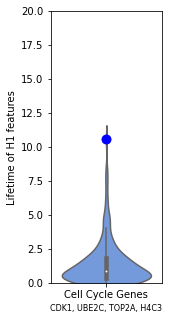

In [21]:
make_plots(gene_sub, 1, 4, 'UMAP - All Cells, Cell Cycle Genes', "AllCells_CellCycleGenes", "blue", sublabel_cycle)

## Select 4 random genes

In [22]:
rand_gene = find_random(4, 0)
print(rand_gene)

['ENSG00000161980', 'ENSG00000126432', 'ENSG00000166598', 'ENSG00000014641']


In [23]:
sublabel_1 = "POLR3K, PRDX5, HSP90B1, MDH1"

gene_sub_rand1 = gene_expression.loc[rand_gene]

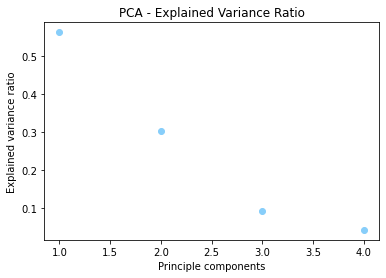

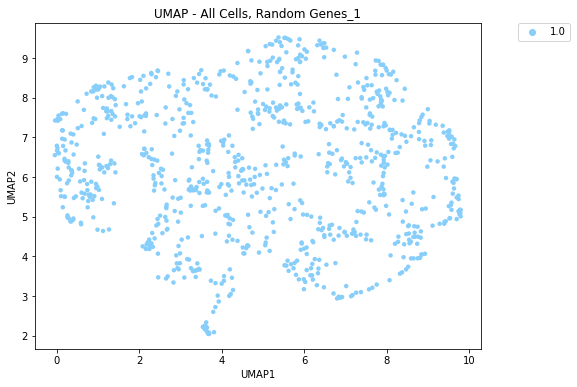

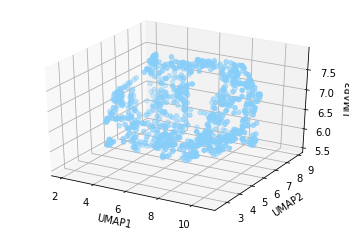

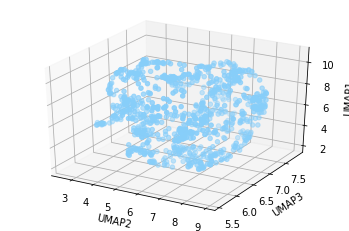

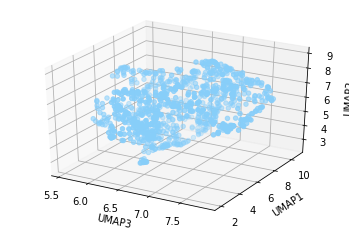

label: (888,)
UMAP: (888, 2)
PCA: (888, 4)
LLe: (888, 4)


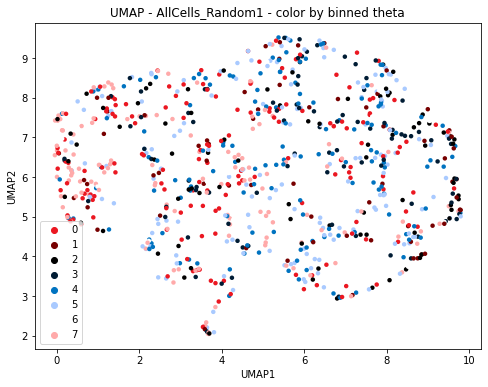

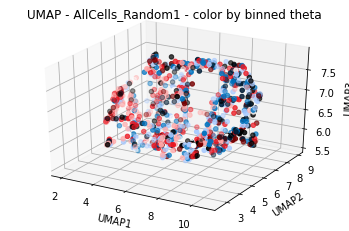

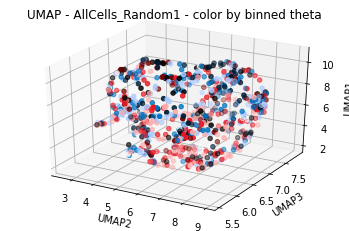

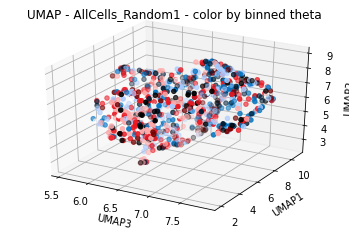

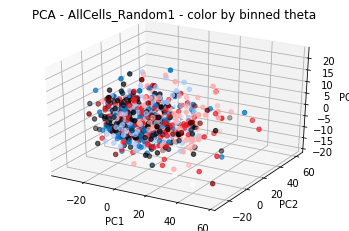

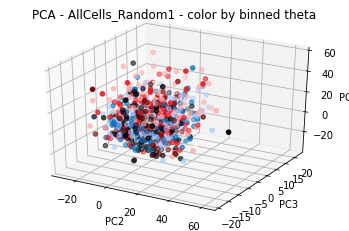

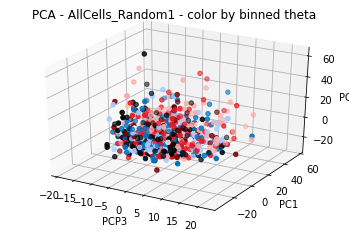

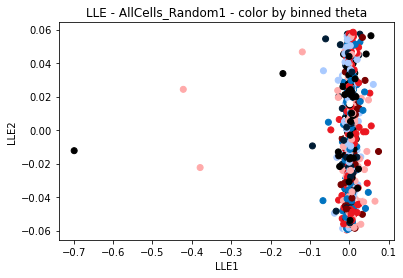

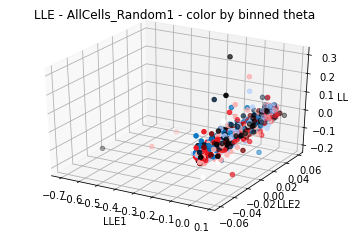

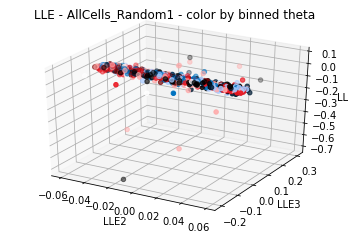

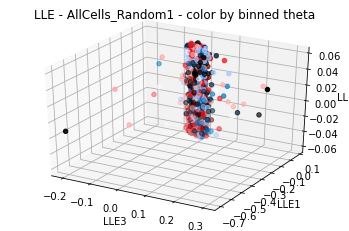

inf


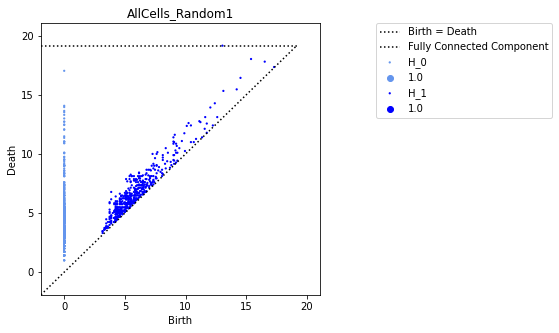

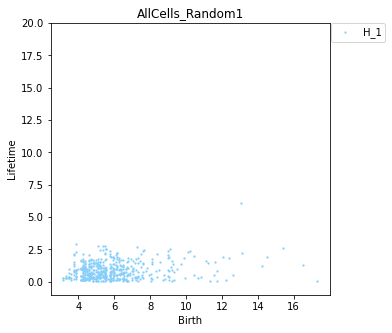

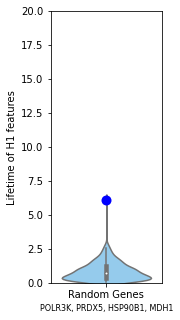

In [24]:
make_plots(gene_sub_rand1, 2, 4, 'UMAP - All Cells, Random Genes_1', "AllCells_Random1", "blue", sublabel_1)

## Select 4 random genes_2

In [25]:
rand_gene = find_random(4, 10)
print(rand_gene)

['ENSG00000111229', 'ENSG00000112514', 'ENSG00000156508', 'ENSG00000167552']


In [26]:
sublabel_2 = "ARPC3, CUTA, EEF1A1, TUBA1A"

gene_sub_rand2 = gene_expression.loc[rand_gene]

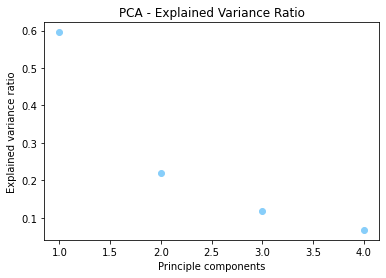

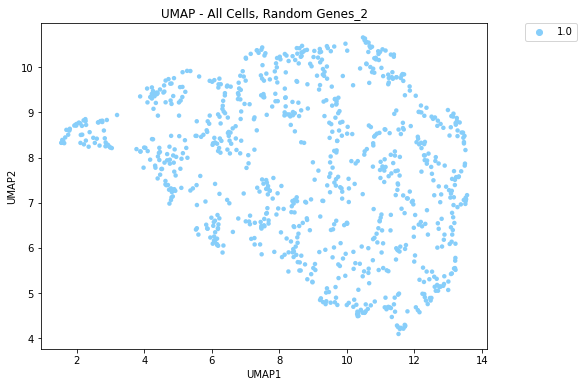

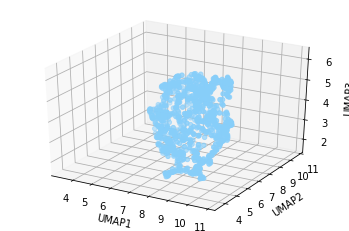

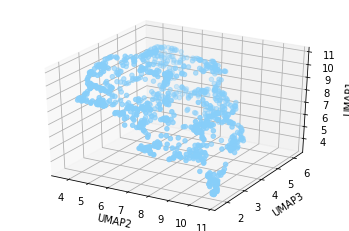

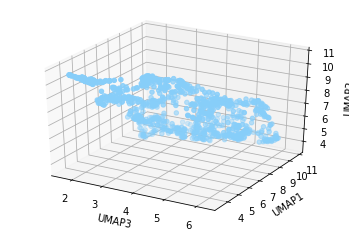

label: (888,)
UMAP: (888, 2)
PCA: (888, 4)
LLe: (888, 4)


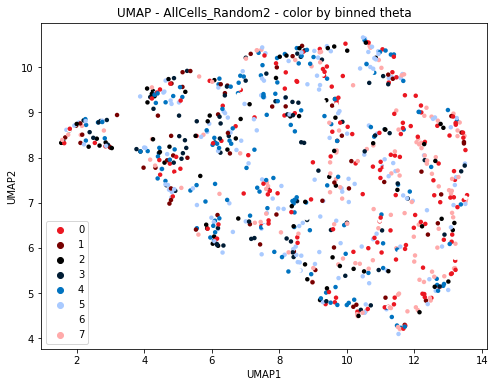

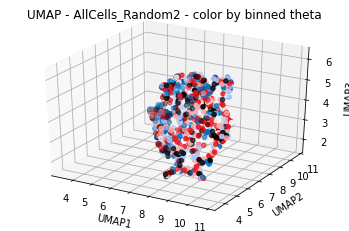

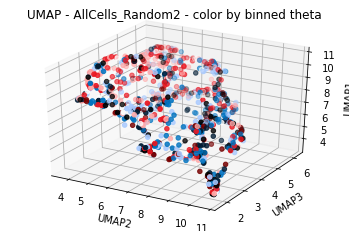

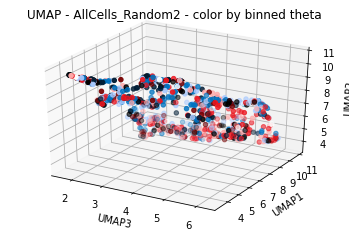

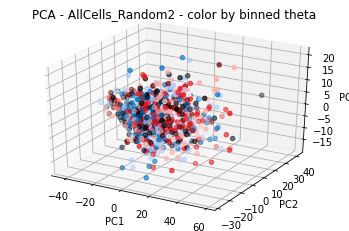

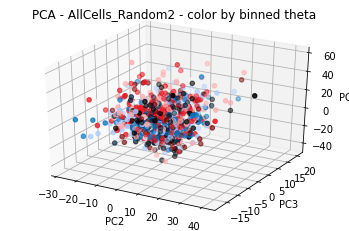

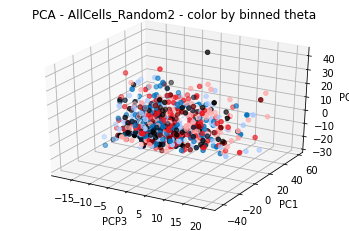

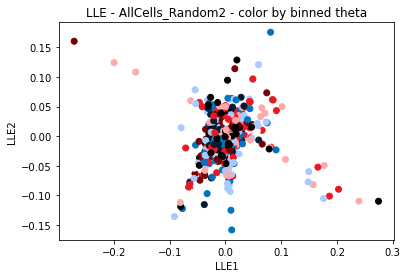

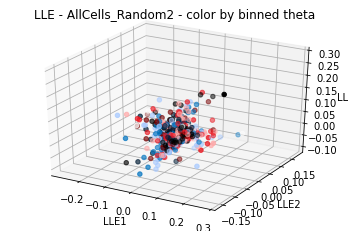

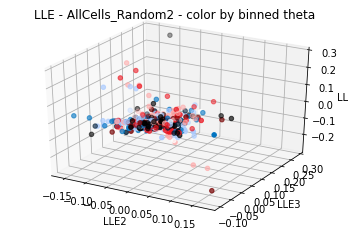

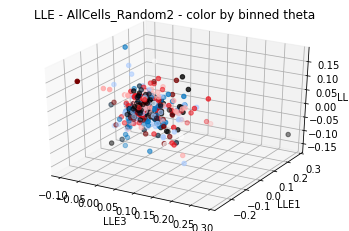

inf


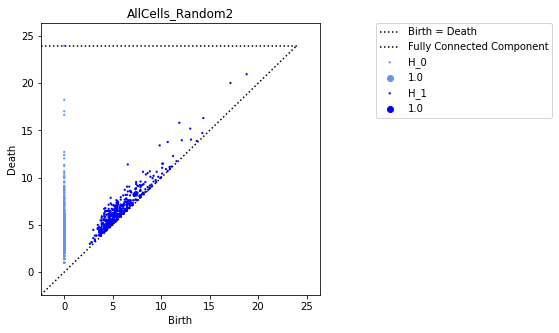

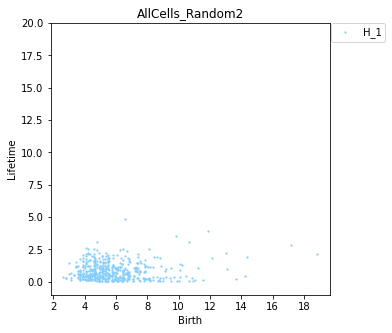

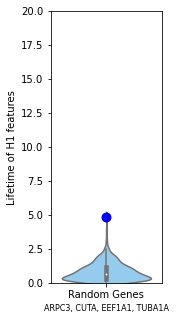

In [27]:
make_plots(gene_sub_rand2, 2, 4, 'UMAP - All Cells, Random Genes_2', "AllCells_Random2", "blue", sublabel_2)

## Select 4 random genes_3

In [28]:
rand_gene = find_random(4, 20)
print(rand_gene)

['ENSG00000118971', 'ENSG00000198856', 'ENSG00000143771', 'ENSG00000133226']


In [29]:
sublabel_3 = "CCND2, OSTC, CNIH4, SRRM1"

gene_sub_rand3 = gene_expression.loc[rand_gene]

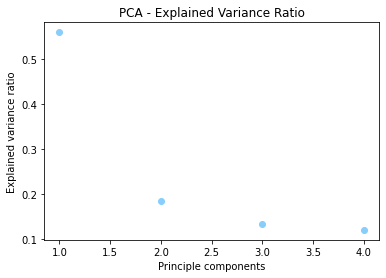

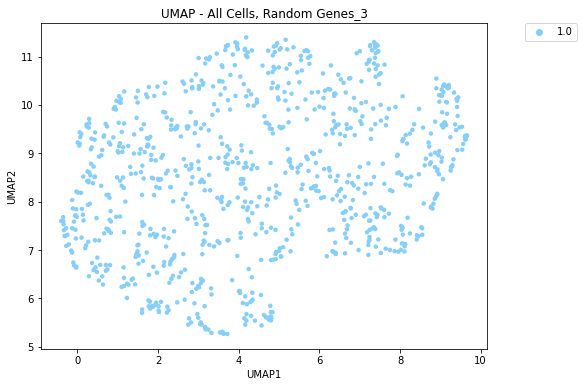

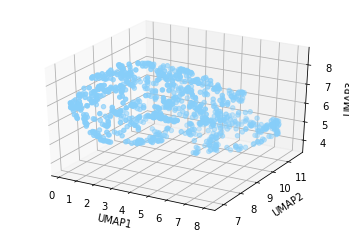

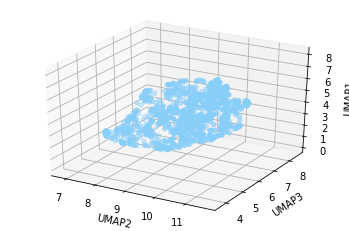

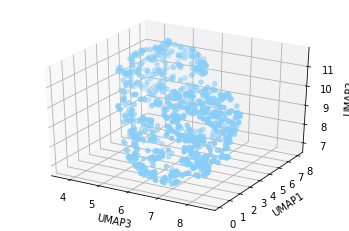

label: (888,)
UMAP: (888, 2)
PCA: (888, 4)
LLe: (888, 4)


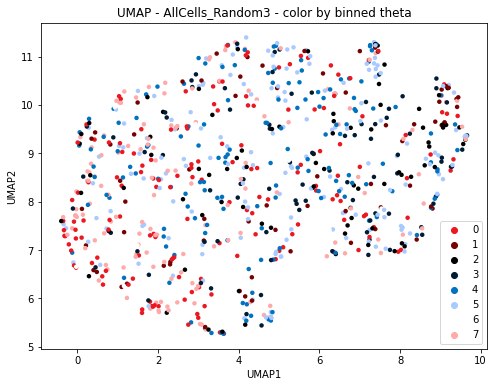

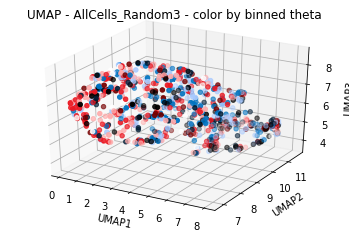

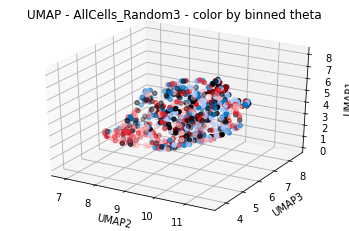

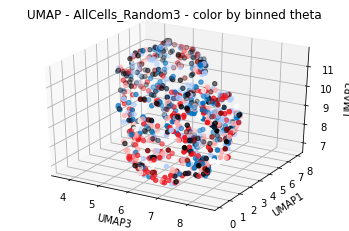

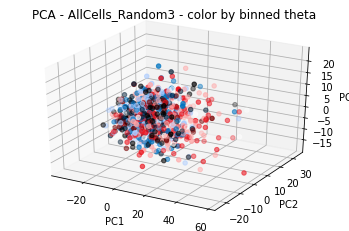

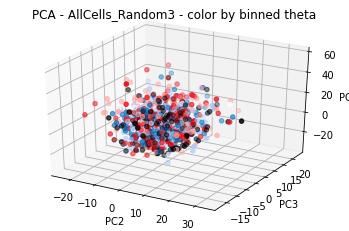

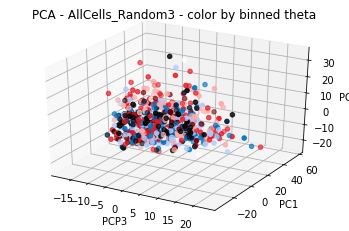

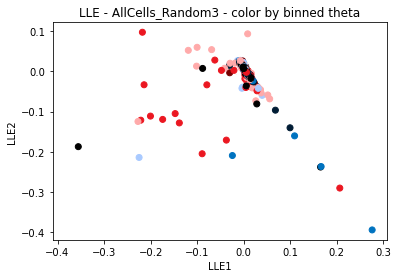

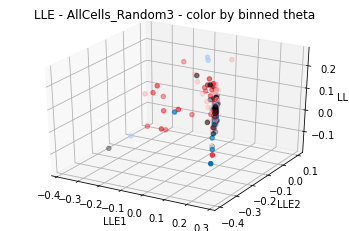

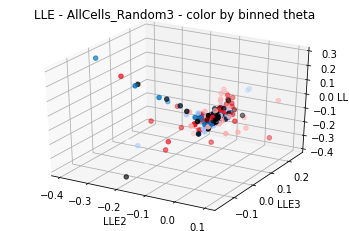

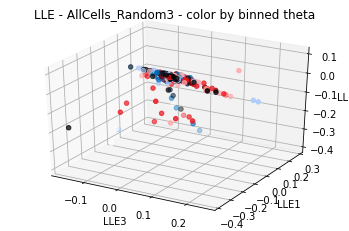

inf


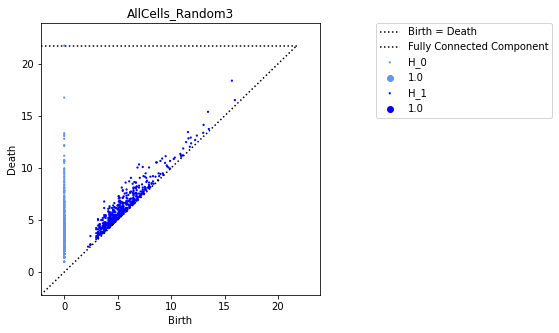

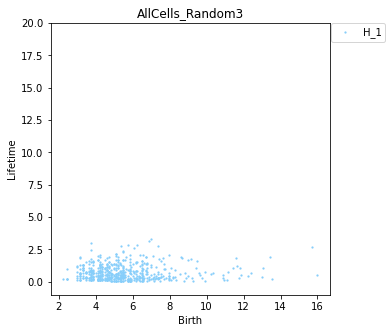

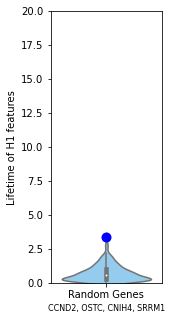

In [30]:
make_plots(gene_sub_rand3, 2, 4, 'UMAP - All Cells, Random Genes_3', "AllCells_Random3", "blue", sublabel_3)

## Select 4 random genes_4

In [31]:
rand_gene = find_random(4, 30)
print(rand_gene)

['ENSG00000172270', 'ENSG00000178982', 'ENSG00000256618', 'ENSG00000115268']


In [32]:
sublabel_4 = "BSG, EIF3K, MTRNR2L1, RPS15"

gene_sub_rand4 = gene_expression.loc[rand_gene]

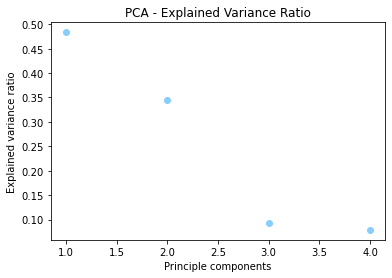

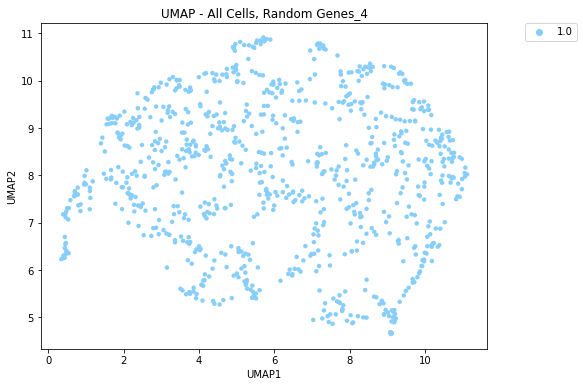

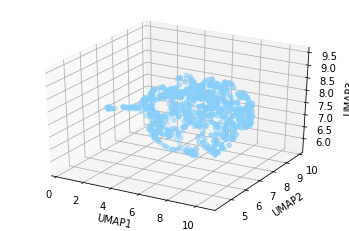

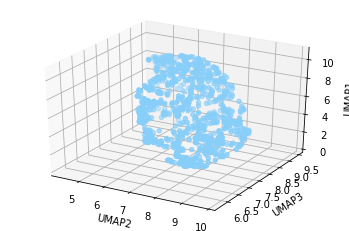

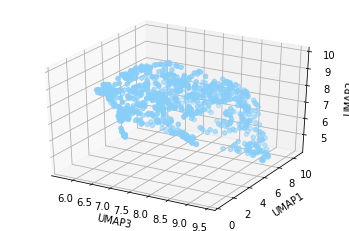

label: (888,)
UMAP: (888, 2)
PCA: (888, 4)
LLe: (888, 4)


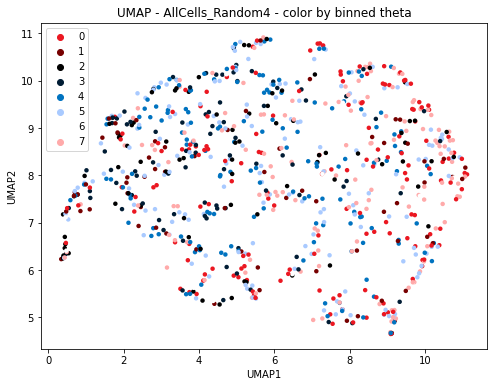

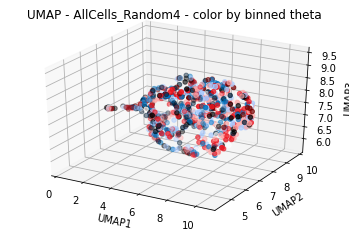

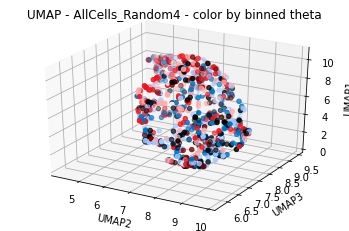

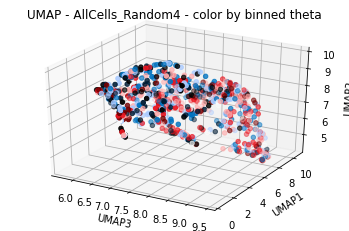

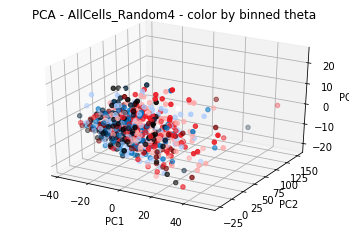

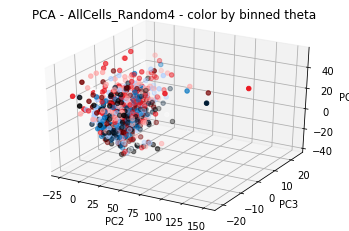

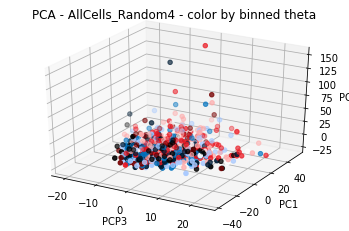

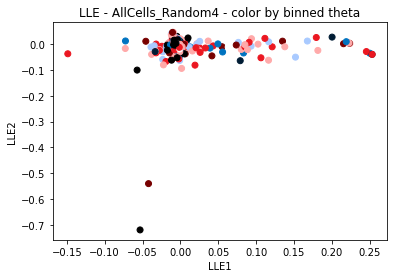

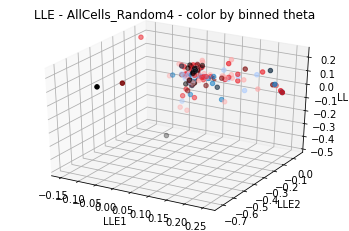

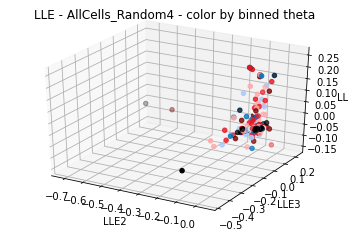

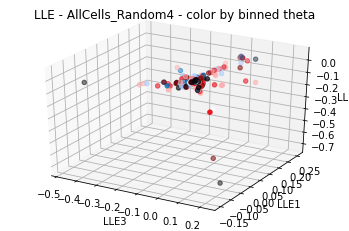

inf


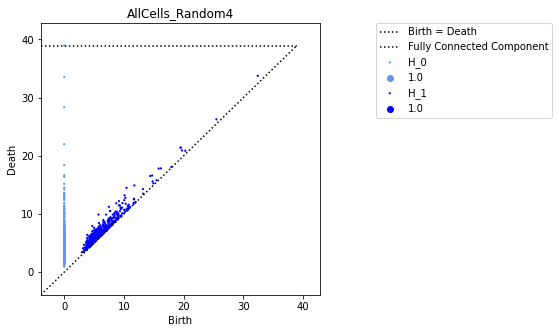

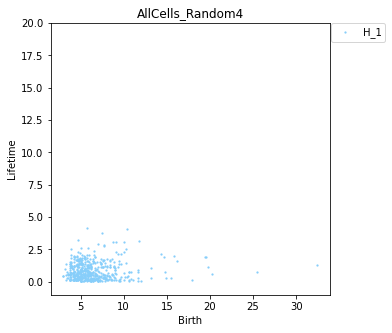

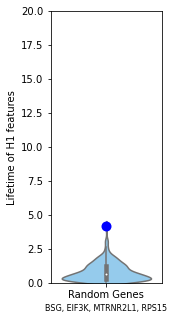

In [33]:
make_plots(gene_sub_rand4, 2, 4, 'UMAP - All Cells, Random Genes_4', "AllCells_Random4", "blue", sublabel_4)

## Select 4 random genes_5

In [34]:
rand_gene = find_random(4, 40)
print(rand_gene)

['ENSG00000116120', 'ENSG00000132507', 'ENSG00000008988', 'ENSG00000120437']


In [35]:
sublabel_5 = "FARSB, EIF5A, RPS20, ACAT2"

gene_sub_rand5 = gene_expression.loc[rand_gene]

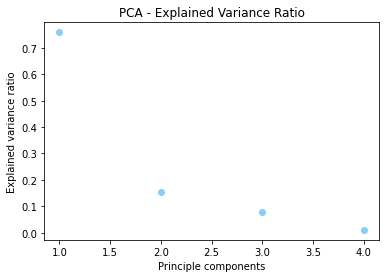

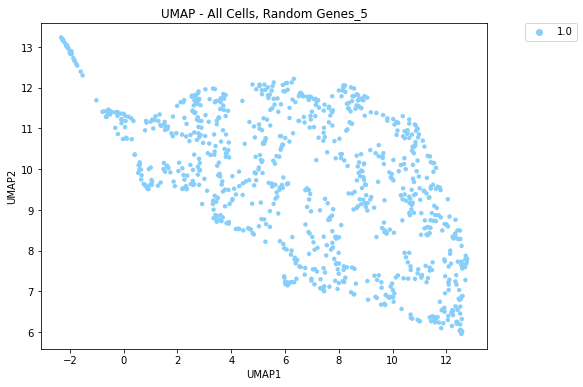

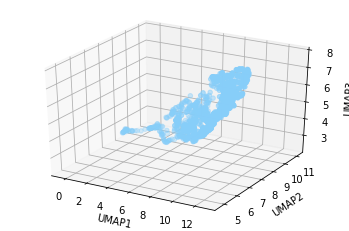

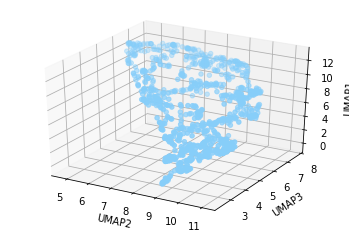

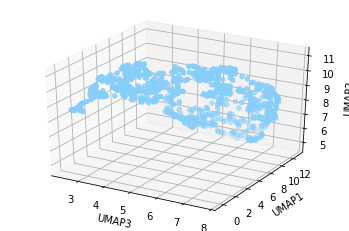

label: (888,)
UMAP: (888, 2)
PCA: (888, 4)
LLe: (888, 4)


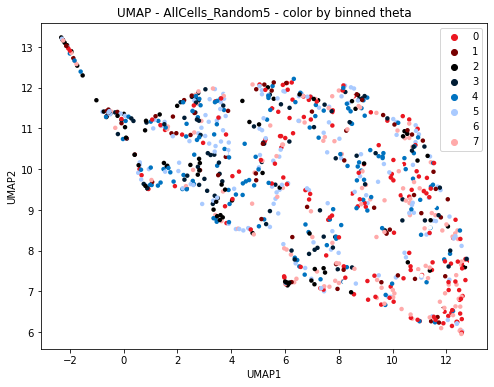

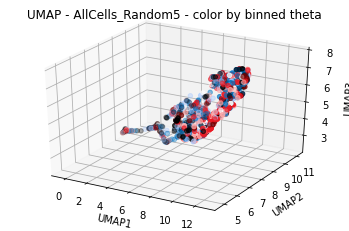

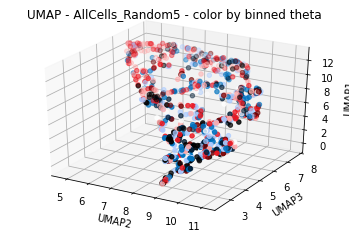

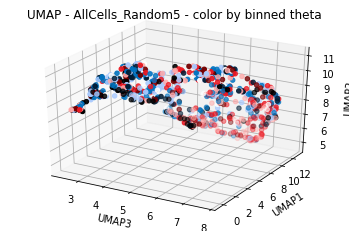

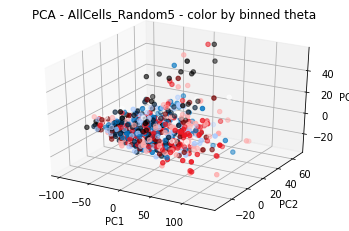

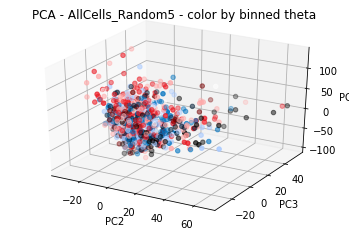

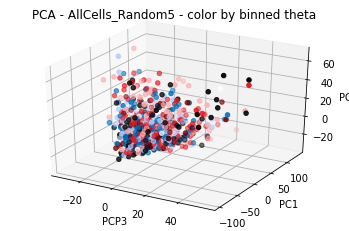

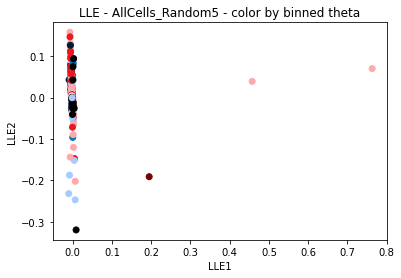

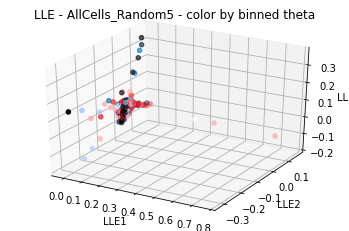

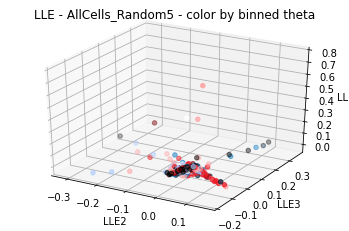

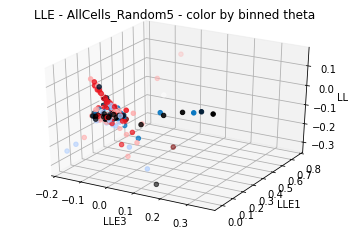

inf


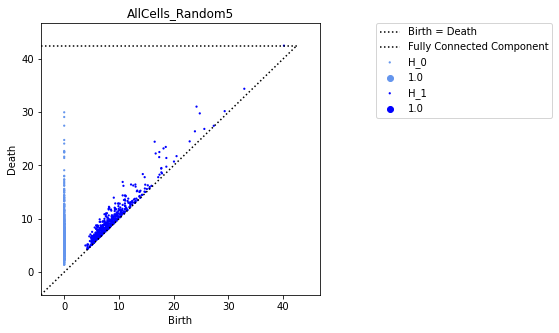

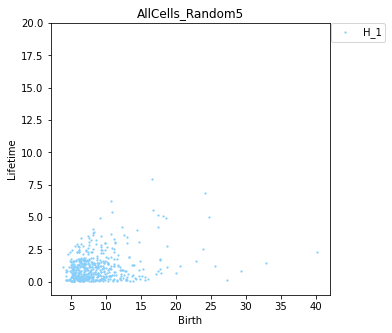

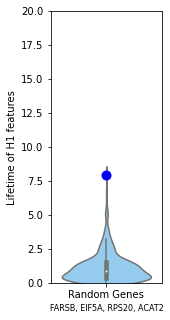

In [36]:
make_plots(gene_sub_rand5, 2, 4, 'UMAP - All Cells, Random Genes_5', "AllCells_Random5", "blue", sublabel_5)

## Cut cycle from UMAP

In [37]:
color_selection = custom_palette.loc["green"]

In [38]:
plt.figure(figsize=(8, 6))
            
sns.scatterplot(embedding_sub[:,0], embedding_sub[:,1], hue = labels["gfp.median.log10sum.adjust"], s = 20, linewidth=0, palette = "coolwarm", hue_norm=(-1,1))
plt.vlines(-1, -2, 9, linestyles ="dotted", colors ="k")
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.title('UMAP - GFP')
plt.legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)
#plt.savefig('.png')
plt.show()

NameError: name 'embedding_sub' is not defined

<Figure size 576x432 with 0 Axes>

In [ ]:
location_include = np.where(embedding_sub[:,0] > -1)[0]
print(location_include.shape)

name_include = []
embedding_include_x = []
embedding_include_y = []

for i in range(location_include.shape[0]):
    name_include.append(gene_expression.columns[location_include[i]])  
    embedding_include_x.append(embedding_sub[location_include[i],0]) 
    embedding_include_y.append(embedding_sub[location_include[i],1]) 
    
include_gene_expression = gene_expression[name_include]
embedding_include_x = np.array(embedding_include_x)
embedding_include_y = np.array(embedding_include_y)
embedding_include_x = np.reshape(embedding_include_x, (embedding_include_x.shape[0],1))
embedding_include_y = np.reshape(embedding_include_y, (embedding_include_x.shape[0],1))

embedding_include = np.append(embedding_include_x, embedding_include_y, axis = 1)

In [ ]:
include_gene_expression.shape

In [ ]:
plt.figure(figsize=(8, 6))
            
sns.scatterplot(embedding_sub[:,0], embedding_sub[:,1], hue = np.ones(embedding_sub.shape[0]), s = 20, linewidth=0, palette = ["lightgrey"])
sns.scatterplot(embedding_include[:,0], embedding_include[:,1], hue = np.ones(embedding_include.shape[0]), s = 20, linewidth=0, palette = [color_selection[1]])
plt.vlines(-1, -2, 9, linestyles ="dotted", colors ="k")
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
#plt.savefig('.png')
plt.show()

In [ ]:
make_plots(include_gene_expression, 0, 20, 'UMAP - Large Loop Cells, All Genes', "LargeLoopCells_AllGenes", "green", sublabel)

In [ ]:
include_gene_expression = gene_sub[name_include]

In [ ]:
make_plots(include_gene_expression, 1, 4, 'UMAP - Large Loop Cells, All Genes', "LargeLoopCells_CellCycleGenes", "green", sublabel_cycle)

In [ ]:
include_gene_expression = gene_sub_rand1[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Large Loop Cells, Random Genes_1', "LargeLoopCells_Random1", "green", sublabel_1)

In [ ]:
include_gene_expression = gene_sub_rand2[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Large Loop Cells, Random Genes_2', "LargeLoopCells_Random2", "green", sublabel_2)

In [ ]:
include_gene_expression = gene_sub_rand3[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Large Loop Cells, Random Genes_3', "LargeLoopCells_Random3", "green", sublabel_3)

In [ ]:
include_gene_expression = gene_sub_rand4[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Large Loop Cells, Random Genes_4', "LargeLoopCells_Random4", "green", sublabel_4)

In [ ]:
include_gene_expression = gene_sub_rand5[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Large Loop Cells, Random Genes_5', "LargeLoopCells_Random5", "green", sublabel_5)

## Cut cycle from UMAP

In [ ]:
color_selection = custom_palette.loc["orange"]

In [ ]:
plt.figure(figsize=(8, 6))
            
sns.scatterplot(embedding_sub[:,0], embedding_sub[:,1], hue = labels["gfp.median.log10sum.adjust"], s = 20, linewidth=0, palette = "coolwarm", hue_norm=(-1,1))
plt.vlines(6, -2, 9, linestyles ="dotted", colors ="k")
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.title('UMAP - GFP')
plt.legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)
#plt.savefig('.png')
plt.show()

In [ ]:
location_include = np.where(embedding_sub[:,0] < 6)[0]
print(location_include.shape)

name_include = []
embedding_include_x = []
embedding_include_y = []

for i in range(location_include.shape[0]):
    name_include.append(gene_expression.columns[location_include[i]])  
    embedding_include_x.append(embedding_sub[location_include[i],0]) 
    embedding_include_y.append(embedding_sub[location_include[i],1]) 
    
include_gene_expression = gene_expression[name_include]
embedding_include_x = np.array(embedding_include_x)
embedding_include_y = np.array(embedding_include_y)
embedding_include_x = np.reshape(embedding_include_x, (embedding_include_x.shape[0],1))
embedding_include_y = np.reshape(embedding_include_y, (embedding_include_x.shape[0],1))

embedding_include = np.append(embedding_include_x, embedding_include_y, axis = 1)

In [ ]:
plt.figure(figsize=(8, 6))
            
sns.scatterplot(embedding_sub[:,0], embedding_sub[:,1], hue = np.ones(embedding_sub.shape[0]), s = 20, linewidth=0, palette = ["lightgrey"])
sns.scatterplot(embedding_include[:,0], embedding_include[:,1], hue = np.ones(embedding_include.shape[0]), s = 20, linewidth=0, palette = [color_selection[1]])
plt.vlines(6, -2, 9, linestyles ="dotted", colors ="k")
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
#plt.savefig('.png')
plt.show()

In [ ]:
make_plots(include_gene_expression, 0, 20, 'UMAP - Cut Cells, All Genes', "CutCells_AllGenes", "orange", sublabel)

In [ ]:
include_gene_expression = gene_sub[name_include]

In [ ]:
make_plots(include_gene_expression, 1, 4, 'UMAP - Cut Cells, Cell Cycle Genes', "CutCells_CellCycleGenes", "orange", sublabel_cycle)

In [ ]:
include_gene_expression = gene_sub_rand1[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Cut Cells, Random Genes_1', "CutCells_Random1", "orange", sublabel_1)

In [ ]:
include_gene_expression = gene_sub_rand2[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Cut Cells, Random Genes_2', "CutCells_Random2", "orange", sublabel_2)

In [ ]:
include_gene_expression = gene_sub_rand3[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Cut Cells, Random Genes_3', "CutCells_Random3", "orange", sublabel_3)

In [ ]:
include_gene_expression = gene_sub_rand4[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Cut Cells, Random Genes_4', "CutCells_Random4", "orange", sublabel_4)

In [ ]:
include_gene_expression = gene_sub_rand5[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Cut Cells, Random Genes_5', "CutCells_Random5", "orange", sublabel_5)

## Cut cycle from UMAP

In [ ]:
color_selection = custom_palette.loc["red"]

In [ ]:
plt.figure(figsize=(8, 6))
            
sns.scatterplot(embedding_sub[:,0], embedding_sub[:,1], hue = labels["gfp.median.log10sum.adjust"], s = 20, linewidth=0, palette = "coolwarm", hue_norm=(-1,1))
plt.vlines(-0.8, -2, 9, linestyles ="dotted", colors ="k")
plt.vlines(10, -2, 9, linestyles ="dotted", colors ="k")
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.title('UMAP - GFP')
plt.legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)
#plt.savefig('.png')
plt.show()

In [ ]:
location_include = np.where((embedding_sub[:,0] < 10) & (embedding_sub[:,0] > -0.8))[0]
print(location_include.shape)

name_include = []
embedding_include_x = []
embedding_include_y = []

for i in range(location_include.shape[0]):
    name_include.append(gene_expression.columns[location_include[i]])  
    embedding_include_x.append(embedding_sub[location_include[i],0]) 
    embedding_include_y.append(embedding_sub[location_include[i],1]) 
    
include_gene_expression = gene_expression[name_include]
embedding_include_x = np.array(embedding_include_x)
embedding_include_y = np.array(embedding_include_y)
embedding_include_x = np.reshape(embedding_include_x, (embedding_include_x.shape[0],1))
embedding_include_y = np.reshape(embedding_include_y, (embedding_include_x.shape[0],1))

embedding_include = np.append(embedding_include_x, embedding_include_y, axis = 1)

In [ ]:
plt.figure(figsize=(8, 6))
            
sns.scatterplot(embedding_sub[:,0], embedding_sub[:,1], hue = np.ones(embedding_sub.shape[0]), s = 20, linewidth=0, palette = ["lightgrey"])
sns.scatterplot(embedding_include[:,0], embedding_include[:,1], hue = np.ones(embedding_include.shape[0]), s = 20, linewidth=0, palette = [color_selection[1]])
plt.vlines(-0.8, -2, 9, linestyles ="dotted", colors ="k")
plt.vlines(10, -2, 9, linestyles ="dotted", colors ="k")
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
#plt.savefig('.png')
plt.show()

In [ ]:
make_plots(include_gene_expression, 0, 20, 'UMAP - Small Loop Cells, All Genes', "SmallLoopCells_CellCycleGenes", "red", sublabel)

In [ ]:
include_gene_expression = gene_sub[name_include]

In [ ]:
make_plots(include_gene_expression, 1, 4, 'UMAP - Small Loop Cells, Cell Cycle Genes', "SmallLoopCells_CellCycleGenes", "red", sublabel_cycle)

In [ ]:
include_gene_expression = gene_sub_rand1[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Small Loop Cells, Random Genes_1', "SmallLoopCells_Random1", "red", sublabel_1)

In [ ]:
include_gene_expression = gene_sub_rand2[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Small Loop Cells, Random Genes_2', "SmallLoopCells_Random2", "red", sublabel_2)

In [ ]:
include_gene_expression = gene_sub_rand3[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Small Loop Cells, Random Genes_3', "SmallLoopCells_Random3", "red", sublabel_3)

In [ ]:
include_gene_expression = gene_sub_rand4[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Small Loop Cells, Random Genes_4', "SmallLoopCells_Random4", "red", sublabel_4)

In [ ]:
include_gene_expression = gene_sub_rand5[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Small Loop Cells, Random Genes_5', "SmallLoopCells_Random5", "red", sublabel_5)

## Cut cycle from UMAP

In [ ]:
color_selection = custom_palette.loc["purple"]

In [ ]:
plt.figure(figsize=(8, 6))
            
sns.scatterplot(embedding_sub[:,0], embedding_sub[:,1], hue = labels["gfp.median.log10sum.adjust"], s = 20, linewidth=0, palette = "coolwarm", hue_norm=(-1,1))
plt.vlines(10, -2, 9, linestyles ="dotted", colors ="k")
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.title('UMAP - GFP')
plt.legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)
#plt.savefig('.png')
plt.show()

In [ ]:
location_include = np.where((embedding_sub[:,0] > 10) & (embedding_sub[:,1] > 4))[0]
print(location_include.shape)

name_include = []
embedding_include_x = []
embedding_include_y = []

for i in range(location_include.shape[0]):
    name_include.append(gene_expression.columns[location_include[i]])  
    embedding_include_x.append(embedding_sub[location_include[i],0]) 
    embedding_include_y.append(embedding_sub[location_include[i],1]) 
    
include_gene_expression = gene_expression[name_include]
embedding_include_x = np.array(embedding_include_x)
embedding_include_y = np.array(embedding_include_y)
embedding_include_x = np.reshape(embedding_include_x, (embedding_include_x.shape[0],1))
embedding_include_y = np.reshape(embedding_include_y, (embedding_include_x.shape[0],1))

embedding_include = np.append(embedding_include_x, embedding_include_y, axis = 1)

In [ ]:
plt.figure(figsize=(8, 6))
            
sns.scatterplot(embedding_sub[:,0], embedding_sub[:,1], hue = np.ones(embedding_sub.shape[0]), s = 20, linewidth=0, palette = ["lightgrey"])
sns.scatterplot(embedding_include[:,0], embedding_include[:,1], hue = np.ones(embedding_include.shape[0]), s = 20, linewidth=0, palette = [color_selection[1]])
plt.vlines(10, -2, 9, linestyles ="dotted", colors ="k")
plt.hlines(4, -6, 13.5, linestyles ="dotted", colors ="k")
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')

plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
#plt.savefig('.png')
plt.show()

In [ ]:
make_plots(include_gene_expression, 0, 20, 'UMAP - Right Cluster Cells, All Genes', "RightClusterCells_AllGenes", "purple", sublabel)

In [ ]:
include_gene_expression = gene_sub[name_include]

In [ ]:
make_plots(include_gene_expression, 1, 4, 'UMAP - Right Cluster Cells, Cell Cycle Genes', "RightClusterCells_CellCycleGenes", "purple", sublabel_cycle)

In [ ]:
include_gene_expression = gene_sub_rand1[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Right Cluster Cells, Random Genes_1', "RightClusterCells_Random1", "purple", sublabel_1)

In [ ]:
include_gene_expression = gene_sub_rand2[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Right Cluster Cells, Random Genes_2', "RightClusterCells_Random2", "purple", sublabel_2)

In [ ]:
include_gene_expression = gene_sub_rand3[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Right Cluster Cells, Random Genes_3', "RightClusterCells_Random3", "purple", sublabel_3)

In [ ]:
include_gene_expression = gene_sub_rand4[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Right Cluster Cells, Random Genes_4', "RightClusterCells_Random4", "purple", sublabel_4)

In [ ]:
include_gene_expression = gene_sub_rand5[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Right Cluster Cells, Random Genes_5', "RightClusterCells_Random5", "purple", sublabel_5)

## Cut cycle from UMAP

In [ ]:
color_selection = custom_palette.loc["teal"]

In [ ]:
plt.figure(figsize=(8, 6))
            
sns.scatterplot(embedding_sub[:,0], embedding_sub[:,1], hue = labels["gfp.median.log10sum.adjust"], s = 20, linewidth=0, palette = "coolwarm", hue_norm=(-1,1))
plt.vlines(-1, -2, 9, linestyles ="dotted", colors ="k")
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.title('UMAP - GFP')
plt.legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)
#plt.savefig('.png')
plt.show()

In [ ]:
location_include = np.where(embedding_sub[:,0] < -1)[0]
print(location_include.shape)

name_include = []
embedding_include_x = []
embedding_include_y = []

for i in range(location_include.shape[0]):
    name_include.append(gene_expression.columns[location_include[i]])  
    embedding_include_x.append(embedding_sub[location_include[i],0]) 
    embedding_include_y.append(embedding_sub[location_include[i],1]) 
    
include_gene_expression = gene_expression[name_include]
embedding_include_x = np.array(embedding_include_x)
embedding_include_y = np.array(embedding_include_y)
embedding_include_x = np.reshape(embedding_include_x, (embedding_include_x.shape[0],1))
embedding_include_y = np.reshape(embedding_include_y, (embedding_include_x.shape[0],1))

embedding_include = np.append(embedding_include_x, embedding_include_y, axis = 1)

In [ ]:
plt.figure(figsize=(8, 6))
            
sns.scatterplot(embedding_sub[:,0], embedding_sub[:,1], hue = np.ones(embedding_sub.shape[0]), s = 20, linewidth=0, palette = ["lightgrey"])
sns.scatterplot(embedding_include[:,0], embedding_include[:,1], hue = np.ones(embedding_include.shape[0]), s = 20, linewidth=0, palette = [color_selection[1]])
plt.vlines(-1, -2, 9, linestyles ="dotted", colors ="k")
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
#plt.savefig('.png')
plt.show()

In [ ]:
make_plots(include_gene_expression, 0, 20, 'UMAP - Left Cluster Cells, All Genes', "LeftClusterCells_CellCycleGenes", "teal", sublabel)

In [ ]:
include_gene_expression = gene_sub[name_include]

In [ ]:
make_plots(include_gene_expression, 1, 4, 'UMAP - Left Cluster Cells, Cell Cycle Genes', "LeftClusterCells_CellCycleGenes", "teal", sublabel_cycle)

In [ ]:
include_gene_expression = gene_sub_rand1[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Left Cluster Cells, Random Genes_1', "LeftClusterCells_Random1", "teal", sublabel_1)

In [ ]:
include_gene_expression = gene_sub_rand2[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Left Cluster Cells, Random Genes_2', "LeftClusterCells_Random2", "teal", sublabel_2)

In [ ]:
include_gene_expression = gene_sub_rand3[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Left Cluster Cells, Random Genes_3', "LeftClusterCells_Random3", "teal", sublabel_3)

In [ ]:
include_gene_expression = gene_sub_rand4[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Left Cluster Cells, Random Genes_4', "LeftClusterCells_Random4", "teal", sublabel_4)

In [ ]:
include_gene_expression = gene_sub_rand5[name_include]

In [ ]:
make_plots(include_gene_expression, 2, 4, 'UMAP - Left Cluster Cells, Random Genes_5', "LeftClusterCells_Random5", "teal", sublabel_5)